<a href="https://colab.research.google.com/github/handawoon0830/02/blob/main/CIFAR10_Classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:03<00:00, 48905270.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  dog horse  deer   dog


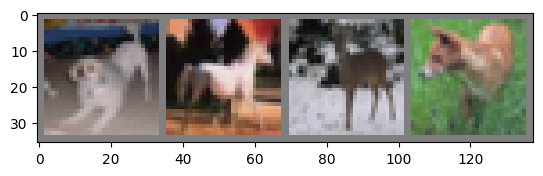

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(input channel, output channel, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = SimpleNet().to(device)

In [ ]:
# VGG Model

cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self.make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


net = VGG11().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model
epochs = 5  # number of epochs

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1, Iteration -  5000] Loss: 0.020
[Epoch - 1, Iteration - 10000] Loss: 0.010
[Epoch - 1] Loss: 0.019
[Epoch - 2, Iteration -  5000] Loss: 0.017
[Epoch - 2, Iteration - 10000] Loss: 0.010
[Epoch - 2] Loss: 0.018
[Epoch - 3, Iteration -  5000] Loss: 0.019
[Epoch - 3, Iteration - 10000] Loss: 0.008
[Epoch - 3] Loss: 0.018
[Epoch - 4, Iteration -  5000] Loss: 0.019
[Epoch - 4, Iteration - 10000] Loss: 0.009
[Epoch - 4] Loss: 0.019
[Epoch - 5, Iteration -  5000] Loss: 0.018
[Epoch - 5, Iteration - 10000] Loss: 0.009
[Epoch - 5] Loss: 0.018
[Epoch - 6, Iteration -  5000] Loss: 0.018
[Epoch - 6, Iteration - 10000] Loss: 0.010
[Epoch - 6] Loss: 0.019
[Epoch - 7, Iteration -  5000] Loss: 0.020
[Epoch - 7, Iteration - 10000] Loss: 0.009
[Epoch - 7] Loss: 0.019
[Epoch - 8, Iteration -  5000] Loss: 0.020
[Epoch - 8, Iteration - 10000] Loss: 0.008
[Epoch - 8] Loss: 0.018
[Epoch - 9, Iteration -  5000] Loss: 0.017
[Epoch - 9, Iteration - 10000] Loss: 0.009
[Epoch - 9] Loss: 0.018
[Epoch - 1

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

NameError: name 'imshow' is not defined

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 82 %
